# GD02 Data Augmentation  
## Objective  
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
- 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

import pandas as pd
import os

import tensorflow_datasets as tfds

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


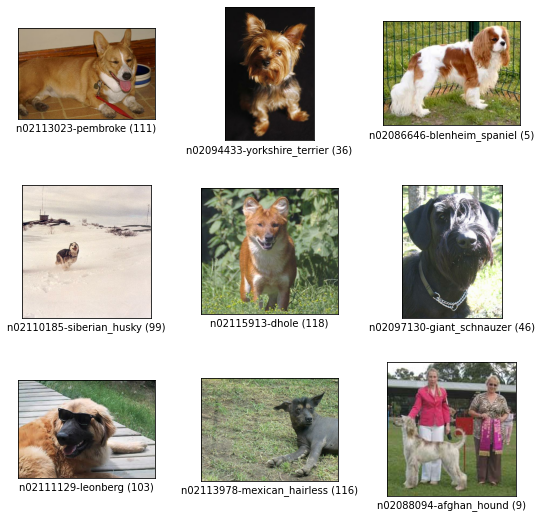

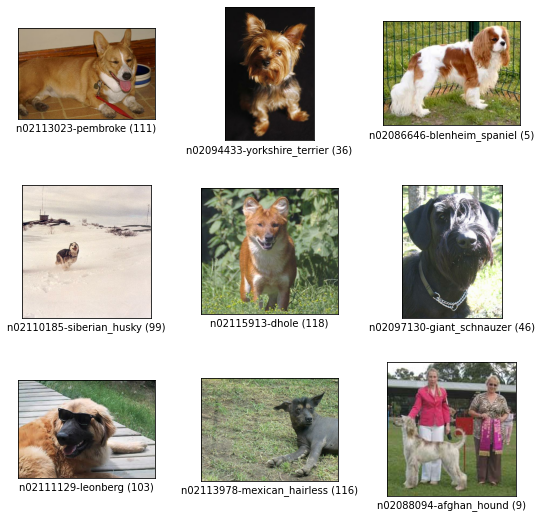

In [6]:
tfds.show_examples(ds_train, ds_info)

전처리 함수를 구현합니다

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

데이터셋 증강함수를 구현합니다  
랜덤플립상하, 밝기조정 외에 랜덤플립좌우, 색조, 채도 변경, 대비를 함게 진행합니다  

In [8]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower = 0.0, upper = 0.3)
    image = tf.image.random_hue(image, max_delta=0.1) #max_delta [0, 0.5], value will randomly picked in the interval 
    image = tf.image.random_saturation(image,lower=0,upper=3)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

# Basic Augmentation

### Basic + Cutmix

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [11]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Basic + Mixup

In [13]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [14]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
            ds = ds.map(
            mixup,
            num_parallel_calls=2
        )                
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

실험하기

In [17]:
EPOCH = 30
LEARNING_RATE = 0.01
BATCH_SIZE = 16

num_classes = ds_info.features["label"].num_classes

In [18]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size = BATCH_SIZE)

### Without Augmentation

In [19]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE)

In [20]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [21]:
resnet50.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Adam 사용시 accuracy가 0.0077부터 10 에폭 즈음 0.02xx가 되는 성능을 보여줍니다    
SGD를 사용하여 훈련을 진행하도록 하겠습니다

In [22]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 159s - loss: 2.1745 - accuracy: 0.4519 - val_loss: 3.4473 - val_accuracy: 0.1981
Epoch 2/30
750/750 - 148s - loss: 0.7401 - accuracy: 0.7965 - val_loss: 1.3622 - val_accuracy: 0.6147
Epoch 3/30
750/750 - 149s - loss: 0.2419 - accuracy: 0.9477 - val_loss: 0.9698 - val_accuracy: 0.7169
Epoch 4/30
750/750 - 149s - loss: 0.0737 - accuracy: 0.9930 - val_loss: 0.9494 - val_accuracy: 0.7261
Epoch 5/30
750/750 - 149s - loss: 0.0390 - accuracy: 0.9977 - val_loss: 0.9440 - val_accuracy: 0.7358
Epoch 6/30
750/750 - 148s - loss: 0.0192 - accuracy: 0.9990 - val_loss: 0.9533 - val_accuracy: 0.7357
Epoch 7/30
750/750 - 149s - loss: 0.0136 - accuracy: 0.9997 - val_loss: 0.9474 - val_accuracy: 0.7396
Epoch 8/30
750/750 - 149s - loss: 0.0292 - accuracy: 0.9985 - val_loss: 0.9874 - val_accuracy: 0.7318
Epoch 9/30
750/750 - 148s - loss: 0.0124 - accuracy: 0.9991 - val_loss: 0.9698 - val_accuracy: 0.7371
Epoch 10/30
750/750 - 149s - loss: 0.0070 - accuracy: 0.9998 - val_loss: 0.9829 - 

In [23]:
resnet50.save("resnet50")

INFO:tensorflow:Assets written to: resnet50/assets


INFO:tensorflow:Assets written to: resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
hist_res50_df = pd.DataFrame(history_resnet50.history) 
hist_res50_csv_file = 'history_resnet50.csv'
with open(hist_res50_csv_file, mode='w') as f:
    hist_res50_df.to_csv(f)

In [26]:
del resnet50
del ds_train_no_aug

### With Cutmix

In [32]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_cutmix = True)

In [33]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [34]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [36]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 152s - loss: 3.7966 - accuracy: 0.2174 - val_loss: 4.0118 - val_accuracy: 0.1266
Epoch 2/30
750/750 - 148s - loss: 2.9295 - accuracy: 0.4417 - val_loss: 1.4888 - val_accuracy: 0.5950
Epoch 3/30
750/750 - 149s - loss: 2.6387 - accuracy: 0.5287 - val_loss: 1.2183 - val_accuracy: 0.6595
Epoch 4/30
750/750 - 149s - loss: 2.4302 - accuracy: 0.5987 - val_loss: 1.2569 - val_accuracy: 0.6504
Epoch 5/30
750/750 - 149s - loss: 2.2636 - accuracy: 0.6511 - val_loss: 1.3739 - val_accuracy: 0.6341
Epoch 6/30
750/750 - 149s - loss: 2.1482 - accuracy: 0.6913 - val_loss: 1.3205 - val_accuracy: 0.6434
Epoch 7/30
750/750 - 149s - loss: 2.0770 - accuracy: 0.7131 - val_loss: 1.1768 - val_accuracy: 0.6786
Epoch 8/30
750/750 - 149s - loss: 1.9775 - accuracy: 0.7352 - val_loss: 1.2212 - val_accuracy: 0.6769
Epoch 9/30
750/750 - 149s - loss: 1.9177 - accuracy: 0.7545 - val_loss: 1.4114 - val_accuracy: 0.6407
Epoch 10/30
750/750 - 149s - loss: 1.8555 - accuracy: 0.7679 - val_loss: 1.1852 - 

In [37]:
resnet50_cutmix.save("resnet50_cutmix")

INFO:tensorflow:Assets written to: resnet50_cutmix/assets


INFO:tensorflow:Assets written to: resnet50_cutmix/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [38]:
hist_res50_cutmix_df = pd.DataFrame(history_resnet50_cutmix.history) 
hist_res50_cutmix_csv_file = 'history_resnet50_cutmix.csv'
with open(hist_res50_cutmix_csv_file, mode='w') as f:
    hist_res50_cutmix_df.to_csv(f)

In [39]:
del resnet50_cutmix
del ds_train_cutmix

### With Mixup

In [40]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_mixup = True)

In [41]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [42]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [43]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 157s - loss: 3.7404 - accuracy: 0.2340 - val_loss: 4.4443 - val_accuracy: 0.0666
Epoch 2/30
750/750 - 150s - loss: 2.8578 - accuracy: 0.4812 - val_loss: 1.5205 - val_accuracy: 0.5779
Epoch 3/30
750/750 - 166s - loss: 2.5871 - accuracy: 0.5826 - val_loss: 1.3163 - val_accuracy: 0.6361
Epoch 4/30
750/750 - 150s - loss: 2.3697 - accuracy: 0.6625 - val_loss: 1.2058 - val_accuracy: 0.6624
Epoch 5/30
750/750 - 150s - loss: 2.2603 - accuracy: 0.7049 - val_loss: 1.2206 - val_accuracy: 0.6641
Epoch 6/30
750/750 - 150s - loss: 2.1301 - accuracy: 0.7493 - val_loss: 1.2492 - val_accuracy: 0.6580
Epoch 7/30
750/750 - 150s - loss: 2.0695 - accuracy: 0.7762 - val_loss: 1.3078 - val_accuracy: 0.6571
Epoch 8/30
750/750 - 150s - loss: 2.0158 - accuracy: 0.7926 - val_loss: 1.4621 - val_accuracy: 0.6068
Epoch 9/30
750/750 - 150s - loss: 1.9689 - accuracy: 0.8099 - val_loss: 1.1691 - val_accuracy: 0.6861
Epoch 10/30
750/750 - 150s - loss: 1.9185 - accuracy: 0.8219 - val_loss: 1.2025 - 

In [44]:
resnet50_mixup.save("resnet50_mixup")

INFO:tensorflow:Assets written to: resnet50_mixup/assets


INFO:tensorflow:Assets written to: resnet50_mixup/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [45]:
hist_res50_mixup_df = pd.DataFrame(history_resnet50_mixup.history) 
hist_res50_mixup_csv_file = 'history_resnet50_mixup.csv'
with open(hist_res50_mixup_csv_file, mode='w') as f:
    hist_res50_mixup_df.to_csv(f)

In [46]:
del resnet50_mixup
del ds_train_mixup

### With Augmentation

In [57]:
ds_train_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True)

In [58]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [59]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [60]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 159s - loss: 4.0621 - accuracy: 0.1041 - val_loss: 2.8956 - val_accuracy: 0.2821
Epoch 2/30
750/750 - 149s - loss: 2.6822 - accuracy: 0.3111 - val_loss: 2.5581 - val_accuracy: 0.3407
Epoch 3/30
750/750 - 149s - loss: 2.1683 - accuracy: 0.4229 - val_loss: 2.6689 - val_accuracy: 0.3426
Epoch 4/30
750/750 - 149s - loss: 1.8124 - accuracy: 0.5067 - val_loss: 2.2014 - val_accuracy: 0.4334
Epoch 5/30
750/750 - 149s - loss: 1.5135 - accuracy: 0.5789 - val_loss: 2.3133 - val_accuracy: 0.4101
Epoch 6/30
750/750 - 149s - loss: 1.3301 - accuracy: 0.6292 - val_loss: 3.0518 - val_accuracy: 0.2942
Epoch 7/30
750/750 - 149s - loss: 1.1436 - accuracy: 0.6803 - val_loss: 2.5879 - val_accuracy: 0.3719
Epoch 8/30
750/750 - 149s - loss: 0.9851 - accuracy: 0.7248 - val_loss: 2.0645 - val_accuracy: 0.4838
Epoch 9/30
750/750 - 149s - loss: 0.8391 - accuracy: 0.7657 - val_loss: 2.3324 - val_accuracy: 0.4286
Epoch 10/30
750/750 - 149s - loss: 0.7329 - accuracy: 0.7948 - val_loss: 2.2032 - 

In [61]:
resnet50_aug.save("resnet50_aug")

INFO:tensorflow:Assets written to: resnet50_aug/assets


INFO:tensorflow:Assets written to: resnet50_aug/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [62]:
hist_res50_aug_df = pd.DataFrame(history_resnet50_aug.history) 
hist_res50_aug_csv_file = 'history_resnet50_aug.csv'
with open(hist_res50_aug_csv_file, mode='w') as f:
    hist_res50_aug_df.to_csv(f)

In [63]:
del resnet50_aug
del ds_train_aug

### With Augmentation + Cutmix

In [19]:
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True, with_cutmix = True)

In [20]:
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 158s - loss: 4.7886 - accuracy: 0.0288 - val_loss: 3.5895 - val_accuracy: 0.1629
Epoch 2/30
750/750 - 148s - loss: 4.1994 - accuracy: 0.1093 - val_loss: 3.1337 - val_accuracy: 0.2410
Epoch 3/30
750/750 - 150s - loss: 3.8669 - accuracy: 0.1788 - val_loss: 3.2995 - val_accuracy: 0.2142
Epoch 4/30
750/750 - 150s - loss: 3.6787 - accuracy: 0.2326 - val_loss: 2.6762 - val_accuracy: 0.3022
Epoch 5/30
750/750 - 166s - loss: 3.5235 - accuracy: 0.2693 - val_loss: 2.1492 - val_accuracy: 0.4317
Epoch 6/30
750/750 - 149s - loss: 3.4275 - accuracy: 0.2995 - val_loss: 2.2441 - val_accuracy: 0.4093
Epoch 7/30
750/750 - 150s - loss: 3.3061 - accuracy: 0.3289 - val_loss: 1.8964 - val_accuracy: 0.4838
Epoch 8/30
750/750 - 166s - loss: 3.2189 - accuracy: 0.3553 - val_loss: 1.9548 - val_accuracy: 0.4788
Epoch 9/30
750/750 - 149s - loss: 3.1456 - accuracy: 0.3793 - val_loss: 1.9989 - val_accuracy: 0.4675
Epoch 10/30
750/750 - 150s - loss: 3.0836 - accuracy: 0.3910 - val_loss: 2.0875 - 

In [23]:
resnet50_aug_cutmix.save("resnet50_aug_cutmix")

INFO:tensorflow:Assets written to: resnet50_aug_cutmix/assets


INFO:tensorflow:Assets written to: resnet50_aug_cutmix/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
hist_res50_aug_cutmix_df = pd.DataFrame(history_resnet50_aug_cutmix.history) 
hist_res50_aug_cutmix_csv_file = 'history_resnet50_aug_cutmix.csv'
with open(hist_res50_aug_cutmix_csv_file, mode='w') as f:
    hist_res50_aug_cutmix_df.to_csv(f)

In [26]:
del resnet50_aug_cutmix
del ds_train_aug_cutmix

### With Augmentation + Mixup

In [27]:
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True, with_mixup = True)

In [28]:
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 - 159s - loss: 4.8071 - accuracy: 0.0233 - val_loss: 3.7700 - val_accuracy: 0.1322
Epoch 2/30
750/750 - 149s - loss: 4.2427 - accuracy: 0.1063 - val_loss: 3.6471 - val_accuracy: 0.2142
Epoch 3/30
750/750 - 149s - loss: 3.8870 - accuracy: 0.1871 - val_loss: 4.0358 - val_accuracy: 0.1811
Epoch 4/30
750/750 - 149s - loss: 3.6759 - accuracy: 0.2447 - val_loss: 3.1733 - val_accuracy: 0.3097
Epoch 5/30
750/750 - 149s - loss: 3.5416 - accuracy: 0.2873 - val_loss: 2.8587 - val_accuracy: 0.3366
Epoch 6/30
750/750 - 149s - loss: 3.4304 - accuracy: 0.3165 - val_loss: 3.0813 - val_accuracy: 0.3443
Epoch 7/30
750/750 - 165s - loss: 3.3302 - accuracy: 0.3487 - val_loss: 2.9697 - val_accuracy: 0.3483
Epoch 8/30
750/750 - 149s - loss: 3.2453 - accuracy: 0.3822 - val_loss: 3.3176 - val_accuracy: 0.2957
Epoch 9/30
750/750 - 149s - loss: 3.1933 - accuracy: 0.4002 - val_loss: 2.4513 - val_accuracy: 0.4479
Epoch 10/30
750/750 - 149s - loss: 3.1269 - accuracy: 0.4175 - val_loss: 3.4602 - 

In [31]:
resnet50_aug_mixup.save("resnet50_aug_mixup")

INFO:tensorflow:Assets written to: resnet50_aug_mixup/assets


INFO:tensorflow:Assets written to: resnet50_aug_mixup/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [32]:
hist_res50_aug_mixup_df = pd.DataFrame(history_resnet50_aug_mixup.history) 
hist_res50_aug_mixup_csv_file = 'history_resnet50_aug_mixup.csv'
with open(hist_res50_aug_mixup_csv_file, mode='w') as f:
    hist_res50_aug_mixup_df.to_csv(f)

In [33]:
del resnet50_aug_mixup
del ds_train_aug_mixup

## Evaluation  
  
Plain, Augmentation, Cutmix, Mixup, Aug+Cutmix, Aug+Mixup  
여섯 개의 조건에서 실험을 진행했습니다  

In [42]:
res_plain =  pd.read_csv("history_resnet50.csv")
res_aug =  pd.read_csv("history_resnet50_aug.csv")
res_mixup =  pd.read_csv("history_resnet50_mixup.csv")
res_cutmix =  pd.read_csv("history_resnet50_cutmix.csv")
res_aug_mixup =  pd.read_csv("history_resnet50_aug_mixup.csv")
res_aug_cutmix =  pd.read_csv("history_resnet50_aug_cutmix.csv")

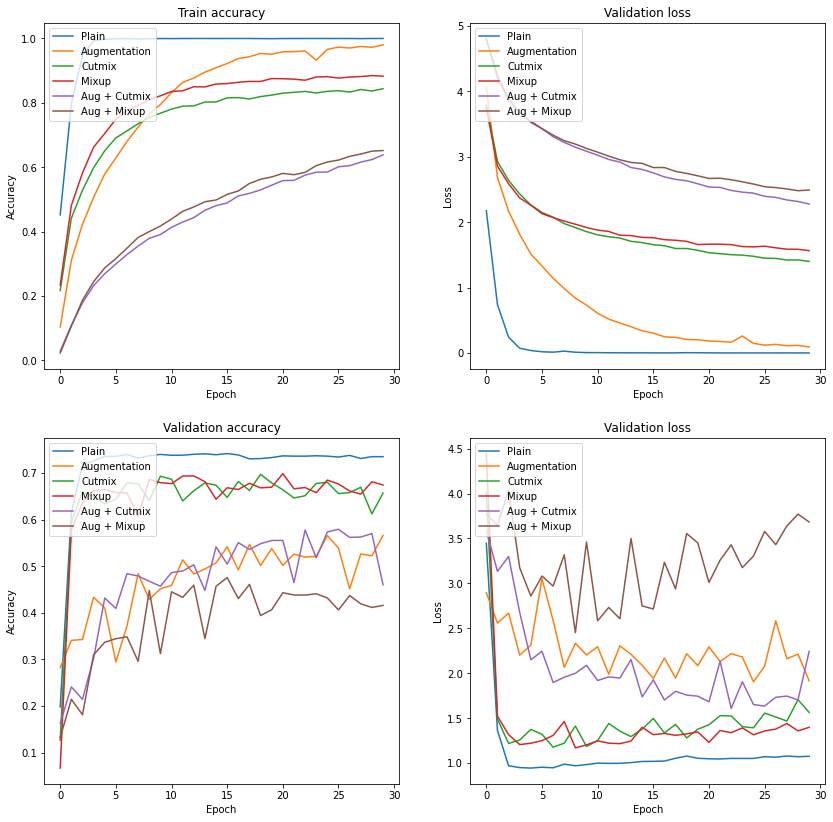

In [51]:
fig = plt.figure(figsize = (14, 14))

plt.subplot(2,2,1)
plt.plot(res_plain['accuracy'])
plt.plot(res_aug['accuracy'])
plt.plot(res_cutmix['accuracy'])
plt.plot(res_mixup['accuracy'])
plt.plot(res_aug_cutmix['accuracy'])
plt.plot(res_aug_mixup['accuracy'])

plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup' , 'Aug + Cutmix' , 'Aug + Mixup'], loc='upper left')


plt.subplot(2,2,2)
plt.plot(res_plain['loss'])
plt.plot(res_aug['loss'])
plt.plot(res_cutmix['loss'])
plt.plot(res_mixup['loss'])
plt.plot(res_aug_cutmix['loss'])
plt.plot(res_aug_mixup['loss'])

plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup' , 'Aug + Cutmix' , 'Aug + Mixup'], loc='upper left')


plt.subplot(2,2,3)
plt.plot(res_plain['val_accuracy'])
plt.plot(res_aug['val_accuracy'])
plt.plot(res_cutmix['val_accuracy'])
plt.plot(res_mixup['val_accuracy'])
plt.plot(res_aug_cutmix['val_accuracy'])
plt.plot(res_aug_mixup['val_accuracy'])

plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup' , 'Aug + Cutmix' , 'Aug + Mixup'], loc='upper left')


plt.subplot(2,2,4)
plt.plot(res_plain['val_loss'])
plt.plot(res_aug['val_loss'])
plt.plot(res_cutmix['val_loss'])
plt.plot(res_mixup['val_loss'])
plt.plot(res_aug_cutmix['val_loss'])
plt.plot(res_aug_mixup['val_loss'])

plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup' , 'Aug + Cutmix' , 'Aug + Mixup'], loc='upper left')

전체적으로, dataset augmentation이 복잡하게 이루어진 경우, 다시 말해 deformation이 심한 경우, 
- 모델의 수렴이 늦어집니다  
- validation accuracy / loss 의 추세가 불안정한 정도가 심합니다  

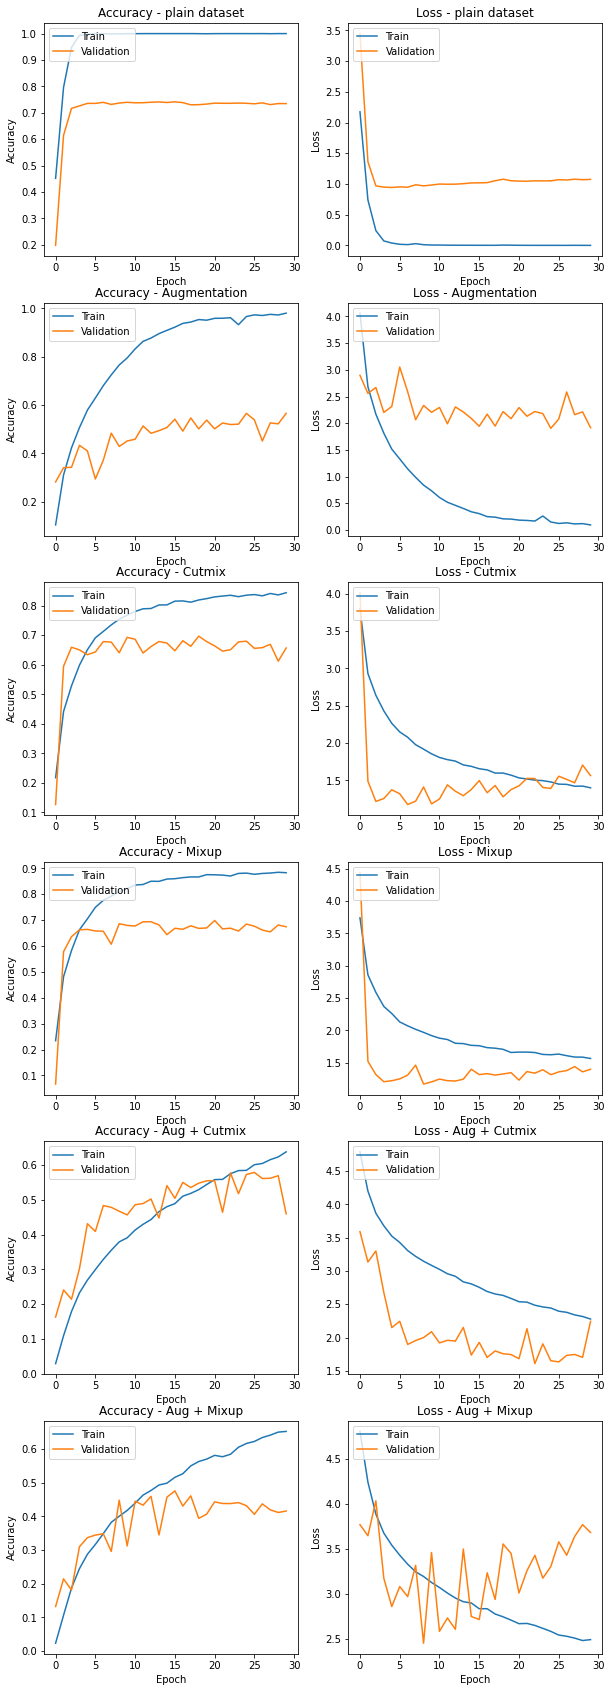

In [49]:
fig = plt.figure(figsize = (10, 30))

plt.subplot(6,2,1)
plt.plot(res_plain['accuracy'])
plt.plot(res_plain['val_accuracy'])
plt.title('Accuracy - plain dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,2)
plt.plot(res_plain['loss'])
plt.plot(res_plain['val_loss'])
plt.title('Loss - plain dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,3)
plt.plot(res_aug['accuracy'])
plt.plot(res_aug['val_accuracy'])
plt.title('Accuracy - Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,4)
plt.plot(res_aug['loss'])
plt.plot(res_aug['val_loss'])
plt.title('Loss - Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,5)
plt.plot(res_cutmix['accuracy'])
plt.plot(res_cutmix['val_accuracy'])
plt.title('Accuracy - Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,6)
plt.plot(res_cutmix['loss'])
plt.plot(res_cutmix['val_loss'])
plt.title('Loss - Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,7)
plt.plot(res_mixup['accuracy'])
plt.plot(res_mixup['val_accuracy'])
plt.title('Accuracy - Mixup')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,8)
plt.plot(res_mixup['loss'])
plt.plot(res_mixup['val_loss'])
plt.title('Loss - Mixup')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,9)
plt.plot(res_aug_cutmix['accuracy'])
plt.plot(res_aug_cutmix['val_accuracy'])
plt.title('Accuracy - Aug + Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,10)
plt.plot(res_aug_cutmix['loss'])
plt.plot(res_aug_cutmix['val_loss'])
plt.title('Loss - Aug + Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,11)
plt.plot(res_aug_mixup['accuracy'])
plt.plot(res_aug_mixup['val_accuracy'])
plt.title('Accuracy - Aug + Mixup')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(6,2,12)
plt.plot(res_aug_mixup['loss'])
plt.plot(res_aug_mixup['val_loss'])
plt.title('Loss - Aug + Mixup')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

#### Plain dataset  
빠르게 모델이 수렴한 후, validation accuraccy & loss 또한 안정적인 추세를 유지하고 있습니다 (val loss 극소량의 증가추세)   
다르게 말해, 모델은 이미 포화상태입니다  
훈련을 더 진행하면 Overfitting 이 일어날 것입니다
#### Augmentation  
비교정 빠르게 모델의 train accuracy가 안정적인 추세에 접어들었습니다만,  
validation accuracy 가 불안정하지만 증가하는 추세를 보입니다  
아직 validation accuracy 가 plain dataset보다 낮지만, train을 더 진행하여 개선점이 있을 지 확인할 수 있을 것 같습니다  
#### CutMix & Mixup  
val loss 가 증가추세에 접어든 듯 한데, train을 더 진행해보아야 확실할 것 같습니다  
두 기법은 비슷한 진행 양상을 보이며, 수치 또한 매우 비슷해 이 데이터셋으로는 '어떤 기법이 더 낫다' 라고 결론내기 쉽지 않습니다  
다만, 이 데이터셋 내에서는 둘 다 30epoch 기준, augmentation을 적용하지 않은 방법보다 나쁜 performance를 보여줍니다  
#### Aug + CutMix & Mixup   
아직 모델이 trainable 합니다  
데이터셋의 deformation이 심하게 일어난 원인으로 추즉됩니다  
validation loss 가 증가추세에 있는데, 모델이 수렴한 후를 지켜봐야 할 것 같습니다

### Future work  
- 모델의 학습을 조금 더 진행하여 추이를 확인하겠습니다 (20 epoch)  
- 모델을 tuning하여, 개선을 시도할 수 있는지 확인하겠습니다 (30 epoch, optimizer sgd > adam)  

### Additional Train

In [19]:
EPOCH = 20

train 과정을 함수화하겠습니다  

In [22]:
def train_step(model_name, dataset) :
    
    model =  keras.models.load_model(model_name)
    
    model.compile(
    loss='categorical_crossentropy',
#    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
    )
    
    history = model.fit(
    dataset, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
    )
    
    print("training done : ", model_name)
    
    model.save(model_name)
    
    return model, history

In [39]:
### Without Augmentation
ds_train_no_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE)

In [40]:
resnet50, history_resnet50 = train_step("resnet50", ds_train_no_aug) 

Epoch 1/20
750/750 - 152s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0718 - val_accuracy: 0.7346
Epoch 2/20
750/750 - 148s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0757 - val_accuracy: 0.7364
Epoch 3/20
750/750 - 149s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0760 - val_accuracy: 0.7352
Epoch 4/20
750/750 - 149s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0800 - val_accuracy: 0.7352
Epoch 5/20
750/750 - 149s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0848 - val_accuracy: 0.7369
Epoch 6/20
750/750 - 149s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0843 - val_accuracy: 0.7334
Epoch 7/20
750/750 - 149s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0899 - val_accuracy: 0.7375
Epoch 8/20
750/750 - 149s - loss: 9.5716e-04 - accuracy: 1.0000 - val_loss: 1.0918 - val_accuracy: 0.7353
Epoch 9/20
750/750 - 149s - loss: 9.5255e-04 - accuracy: 1.0000 - val_loss: 1.0937 - val_accuracy: 0.7361
Epoch 10/20
750/750 - 149s - loss: 8.4273e-04 - accuracy: 1.0000 - val_los

INFO:tensorflow:Assets written to: resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [41]:
hist_res50_df = pd.DataFrame(history_resnet50.history) 
hist_res50_csv_file = 'history_resnet50_2.csv'
with open(hist_res50_csv_file, mode='w') as f:
    hist_res50_df.to_csv(f)

In [42]:
del resnet50
del ds_train_no_aug

In [ ]:
####

In [43]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_cutmix = True)

In [44]:
resnet50_cutmix, history_resnet50_cutmix = train_step("resnet50_cutmix", ds_train_cutmix) 

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 - 159s - loss: 1.3931 - accuracy: 0.8440 - val_loss: 1.7638 - val_accuracy: 0.6124
Epoch 2/20
750/750 - 150s - loss: 1.3904 - accuracy: 0.8457 - val_loss: 1.5390 - val_accuracy: 0.6664
Epoch 3/20
750/750 - 150s - loss: 1.3758 - accuracy: 0.8382 - val_loss: 1.5039 - val_accuracy: 0.6659
Epoch 4/20
750/750 - 166s - loss: 1.3436 - accuracy: 0.8514 - val_loss: 1.4762 - val_accuracy: 0.6750
Epoch 5/20
750/750 - 150s - loss: 1.3419 - accuracy: 0.8473 - val_loss: 1.4644 - val_accuracy: 0.6838
Epoch 6/20
750/750 - 150s - loss: 1.3461 - accuracy: 0.8426 - val_loss: 1.4999 - val_accuracy: 0.6839
Epoch 7/20
750/750 - 150s - loss: 1.3065 - accuracy: 0.8449 - val_loss: 1.5763 - val_accuracy: 0.6552
Epoch 8/20
750/750 - 150s - loss: 1.3085 - accuracy: 0.8508 - val_loss: 1.7522 - val_accuracy: 0.6273
Epoch 9/20
750/750 - 150s - loss: 1.3097 - accuracy: 0.8472 - val_loss: 1.4541 - val_accuracy: 0.6797
Epoch 10/20
750/750 - 150s - loss: 1.3042 - accuracy: 0.8460 - val_loss: 1.4096 - 

INFO:tensorflow:Assets written to: resnet50_cutmix/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [45]:
hist_res50_cutmix_df = pd.DataFrame(history_resnet50_cutmix.history) 
hist_res50_cutmix_csv_file = 'history_resnet50_cutmix_2.csv'
with open(hist_res50_cutmix_csv_file, mode='w') as f:
    hist_res50_cutmix_df.to_csv(f)

In [46]:
del resnet50_cutmix
del ds_train_cutmix

In [ ]:
####

In [52]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_mixup = True)

In [53]:
resnet50_mixup, history_resnet50_mixup = train_step("resnet50_mixup", ds_train_mixup) 

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 - 168s - loss: 1.5691 - accuracy: 0.8825 - val_loss: 1.4461 - val_accuracy: 0.6491
Epoch 2/20
750/750 - 148s - loss: 1.5524 - accuracy: 0.8852 - val_loss: 1.5254 - val_accuracy: 0.6285
Epoch 3/20
750/750 - 150s - loss: 1.5339 - accuracy: 0.8871 - val_loss: 1.3758 - val_accuracy: 0.6688
Epoch 4/20
750/750 - 165s - loss: 1.5305 - accuracy: 0.8877 - val_loss: 1.4396 - val_accuracy: 0.6632
Epoch 5/20
750/750 - 150s - loss: 1.5203 - accuracy: 0.8968 - val_loss: 1.3743 - val_accuracy: 0.6676
Epoch 6/20
750/750 - 150s - loss: 1.5061 - accuracy: 0.8882 - val_loss: 1.3696 - val_accuracy: 0.6656
Epoch 7/20
750/750 - 150s - loss: 1.5098 - accuracy: 0.8957 - val_loss: 1.3913 - val_accuracy: 0.6804
Epoch 8/20
750/750 - 150s - loss: 1.5029 - accuracy: 0.8932 - val_loss: 1.3708 - val_accuracy: 0.6825
Epoch 9/20
750/750 - 150s - loss: 1.5130 - accuracy: 0.8914 - val_loss: 1.4177 - val_accuracy: 0.6663
Epoch 10/20
750/750 - 150s - loss: 1.4891 - accuracy: 0.8912 - val_loss: 1.4843 - 

INFO:tensorflow:Assets written to: resnet50_mixup/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [54]:
hist_res50_mixup_df = pd.DataFrame(history_resnet50_mixup.history) 
hist_res50_mixup_csv_file = 'history_resnet50_mixup_2.csv'
with open(hist_res50_mixup_csv_file, mode='w') as f:
    hist_res50_mixup_df.to_csv(f)

In [55]:
del resnet50_mixup
del ds_train_mixup

In [56]:
###

In [57]:
ds_train_aug = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True)

In [58]:
resnet50_aug, history_resnet50_aug = train_step("resnet50_aug", ds_train_aug)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 - 159s - loss: 0.1001 - accuracy: 0.9776 - val_loss: 2.1995 - val_accuracy: 0.5366
Epoch 2/20
750/750 - 148s - loss: 0.1073 - accuracy: 0.9753 - val_loss: 2.1175 - val_accuracy: 0.5438
Epoch 3/20
750/750 - 149s - loss: 0.0990 - accuracy: 0.9772 - val_loss: 2.1697 - val_accuracy: 0.5511
Epoch 4/20
750/750 - 149s - loss: 0.0912 - accuracy: 0.9803 - val_loss: 2.4346 - val_accuracy: 0.4990
Epoch 5/20
750/750 - 149s - loss: 0.0870 - accuracy: 0.9811 - val_loss: 2.5227 - val_accuracy: 0.4768
Epoch 6/20
750/750 - 149s - loss: 0.0883 - accuracy: 0.9797 - val_loss: 2.3442 - val_accuracy: 0.5210
Epoch 7/20
750/750 - 149s - loss: 0.0793 - accuracy: 0.9845 - val_loss: 2.3609 - val_accuracy: 0.5238
Epoch 8/20
750/750 - 148s - loss: 0.0858 - accuracy: 0.9807 - val_loss: 2.0921 - val_accuracy: 0.5589
Epoch 9/20
750/750 - 149s - loss: 0.0762 - accuracy: 0.9833 - val_loss: 2.0419 - val_accuracy: 0.5683
Epoch 10/20
750/750 - 148s - loss: 0.0784 - accuracy: 0.9823 - val_loss: 2.2339 - 

INFO:tensorflow:Assets written to: resnet50_aug/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [59]:
hist_res50_aug_df = pd.DataFrame(history_resnet50_aug.history) 
hist_res50_aug_csv_file = 'history_resnet50_aug_2.csv'
with open(hist_res50_aug_csv_file, mode='w') as f:
    hist_res50_aug_df.to_csv(f)

In [60]:
del resnet50_aug
del ds_train_aug

In [61]:
####

In [20]:
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True, with_cutmix = True)

In [23]:
resnet50_aug_cutmix, history_resnet50_aug_cutmix = train_step("resnet50_aug_cutmix", ds_train_aug_cutmix)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 - 163s - loss: 2.2500 - accuracy: 0.6465 - val_loss: 1.8454 - val_accuracy: 0.5478
Epoch 2/20
750/750 - 148s - loss: 2.2451 - accuracy: 0.6499 - val_loss: 1.8267 - val_accuracy: 0.5500
Epoch 3/20
750/750 - 148s - loss: 2.1730 - accuracy: 0.6704 - val_loss: 1.7176 - val_accuracy: 0.5761
Epoch 4/20
750/750 - 149s - loss: 2.2051 - accuracy: 0.6578 - val_loss: 1.7454 - val_accuracy: 0.5693
Epoch 5/20
750/750 - 148s - loss: 2.1716 - accuracy: 0.6654 - val_loss: 1.9294 - val_accuracy: 0.5351
Epoch 6/20
750/750 - 148s - loss: 2.1725 - accuracy: 0.6730 - val_loss: 1.7952 - val_accuracy: 0.5526
Epoch 7/20
750/750 - 148s - loss: 2.1580 - accuracy: 0.6793 - val_loss: 1.8647 - val_accuracy: 0.5520
Epoch 8/20
750/750 - 148s - loss: 2.1265 - accuracy: 0.6832 - val_loss: 1.8557 - val_accuracy: 0.5492
Epoch 9/20
750/750 - 148s - loss: 2.0838 - accuracy: 0.6965 - val_loss: 1.7538 - val_accuracy: 0.5739
Epoch 10/20
750/750 - 149s - loss: 2.0701 - accuracy: 0.6983 - val_loss: 1.8481 - 

INFO:tensorflow:Assets written to: resnet50_aug_cutmix/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
hist_res50_aug_cutmix_df = pd.DataFrame(history_resnet50_aug_cutmix.history) 
hist_res50_aug_cutmix_csv_file = 'history_resnet50_aug_cutmix_2.csv'
with open(hist_res50_aug_cutmix_csv_file, mode='w') as f:
    hist_res50_aug_cutmix_df.to_csv(f)

In [25]:
del resnet50_aug_cutmix
del ds_train_aug_cutmix

In [26]:
####

In [27]:
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, False, BATCH_SIZE, with_aug = True, with_mixup = True)

In [28]:
resnet50_aug_mixup, history_resnet50_aug_mixup = train_step("resnet50_aug_mixup", ds_train_aug_mixup)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 - 160s - loss: 2.4742 - accuracy: 0.6528 - val_loss: 4.3851 - val_accuracy: 0.3590
Epoch 2/20
750/750 - 149s - loss: 2.4594 - accuracy: 0.6602 - val_loss: 2.9836 - val_accuracy: 0.4745
Epoch 3/20
750/750 - 149s - loss: 2.4408 - accuracy: 0.6682 - val_loss: 3.4492 - val_accuracy: 0.4349
Epoch 4/20
750/750 - 149s - loss: 2.4246 - accuracy: 0.6753 - val_loss: 3.3032 - val_accuracy: 0.4488
Epoch 5/20
750/750 - 149s - loss: 2.3932 - accuracy: 0.6724 - val_loss: 3.2182 - val_accuracy: 0.4728
Epoch 6/20
750/750 - 149s - loss: 2.3962 - accuracy: 0.6802 - val_loss: 3.4609 - val_accuracy: 0.4347
Epoch 7/20
750/750 - 149s - loss: 2.3820 - accuracy: 0.6819 - val_loss: 3.9611 - val_accuracy: 0.3793
Epoch 8/20
750/750 - 149s - loss: 2.3846 - accuracy: 0.6803 - val_loss: 3.3573 - val_accuracy: 0.4520
Epoch 9/20
750/750 - 149s - loss: 2.3619 - accuracy: 0.6871 - val_loss: 3.5222 - val_accuracy: 0.4269
Epoch 10/20
750/750 - 149s - loss: 2.3347 - accuracy: 0.6963 - val_loss: 3.4961 - 

INFO:tensorflow:Assets written to: resnet50_aug_mixup/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [44]:
hist_res50_aug_mixup_df = pd.DataFrame(history_resnet50_aug_mixup.history) 
hist_res50_aug_mixup_csv_file = 'history_resnet50_aug_mixup_2.csv'
with open(hist_res50_aug_mixup_csv_file, mode='w') as f:
    hist_res50_aug_mixup_df.to_csv(f)

In [30]:
del resnet50_aug_mixup
del ds_train_aug_mixup

In [20]:
res_plain =  pd.read_csv("history_resnet50.csv")
res_aug =  pd.read_csv("history_resnet50_aug.csv")
res_mixup =  pd.read_csv("history_resnet50_mixup.csv")
res_cutmix =  pd.read_csv("history_resnet50_cutmix.csv")
res_aug_mixup =  pd.read_csv("history_resnet50_aug_mixup.csv")
res_aug_cutmix =  pd.read_csv("history_resnet50_aug_cutmix.csv")

In [21]:
res_plain2 =  pd.read_csv("history_resnet50_2.csv")
res_aug2 =  pd.read_csv("history_resnet50_aug_2.csv")
res_mixup2 =  pd.read_csv("history_resnet50_mixup_2.csv")
res_cutmix2 =  pd.read_csv("history_resnet50_cutmix_2.csv")

In [22]:
# 실험결과 history 저장을 덮어써서 ㅋㅋㅋㅋㅠㅠㅠㅠㅠㅋ aug_cutmix 와 aug_mixup은 화면에 찍힌 결과를 저장하여 쓰도록 하겠습니다  
# 모델 훈련은 정상적으로 진행되었습니다

res_aug_cutmix2 = pd.DataFrame()
res_aug_cutmix2["loss"] = [2.2500, 2.2451, 2.1730, 2.2051, 2.1716, 2.1725, 2.1580, 2.1265, 2.0838, 2.0701, 2.0677, 2.0526, 2.0467, 2.0006, 2.0049, 1.9888, 1.9587, 1.9595, 1.9285, 1.9222]
res_aug_cutmix2["accuracy"] = [0.6465, 0.6499, 0.6704, 0.6578, 0.6654, 0.6730, 0.6793, 0.6832, 0.6965, 0.6983, 0.7057, 0.7025, 0.7066, 0.7207, 0.7180, 0.7159, 0.7262, 0.7297, 0.7358, 0.7412]
res_aug_cutmix2["val_loss"] = [1.8454, 1.8267, 1.7176, 1.7454, 1.9294, 1.7952, 1.8647, 1.8557, 1.7538, 1.8481, 1.7508, 1.7895, 1.7642, 1.8211, 1.8346, 1.9331, 2.0483, 1.8187, 1.8509, 1.9505]
res_aug_cutmix2["val_accuracy"] = [0.5478, 0.5500, 0.5761, 0.5693, 0.5351, 0.5526, 0.5520, 0.5492, 0.5739, 0.5555, 0.5719, 0.5683, 0.5831, 0.5634, 0.5624, 0.5417, 0.5161, 0.5659, 0.5617, 0.5396]

res_aug_mixup2 = pd.DataFrame()
res_aug_mixup2["loss"] = [2.4742, 2.4594, 2.4408, 2.4246, 2.3932, 2.3962, 2.3820, 2.3846, 2.3619, 2.3347, 2.3426, 2.3094, 2.3275, 2.3247, 2.2714, 2.2731, 2.2996, 2.2684, 2.2530, 2.2544]
res_aug_mixup2["accuracy"] = [0.6528, 0.6602, 0.6682, 0.6753, 0.6724, 0.6802, 0.6819, 0.6803, 0.6871, 0.6963, 0.6978, 0.7108, 0.6959, 0.7022, 0.7107, 0.7175, 0.7074, 0.7168, 0.7191, 0.7207]
res_aug_mixup2["val_loss"] = [4.3851, 2.9836, 3.4492, 3.3032, 3.2182, 3.4609, 3.9611, 3.3573, 3.5222, 3.4961, 3.1483, 3.4695, 4.0943, 3.9110, 4.0075, 3.4164, 4.0311, 3.8026, 3.8788, 3.9398]
res_aug_mixup2["val_accuracy"] = [0.3590, 0.4745, 0.4349, 0.4488, 0.4728, 0.4347, 0.3793, 0.4520, 0.4269, 0.4523, 0.4696, 0.4439, 0.3883, 0.3981, 0.3994, 0.4304, 0.3923, 0.4148, 0.3968, 0.4024]

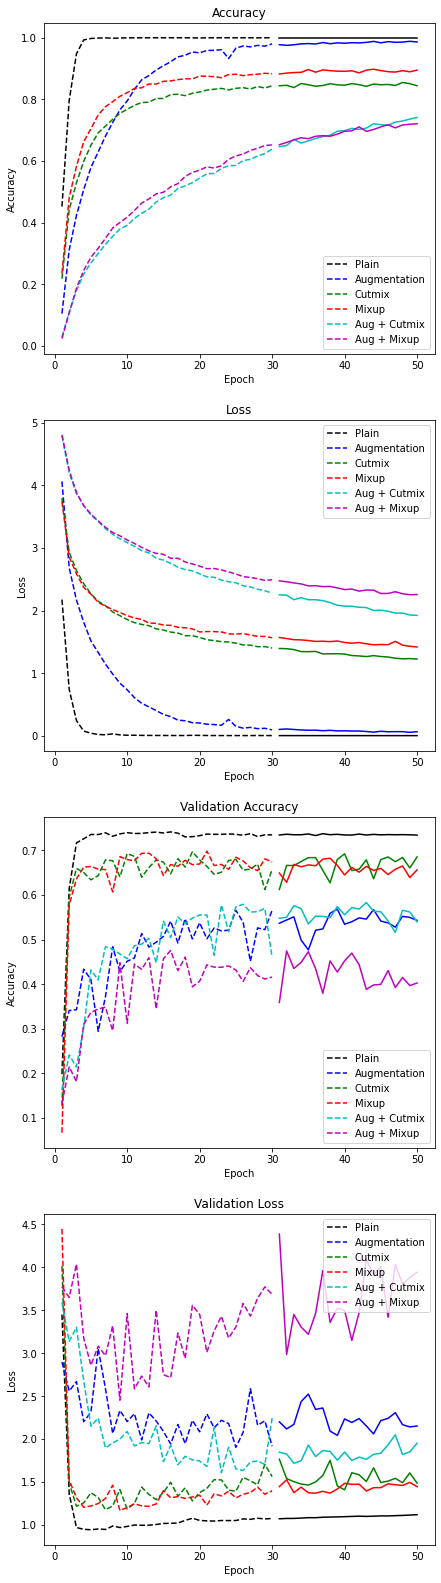

In [35]:
fig = plt.figure(figsize = (7, 28))

epoch = list(range(1, 51))

plt.subplot(4, 1, 1)

plt.plot(epoch[:30], res_plain['accuracy'], 'k--')
plt.plot(epoch[:30], res_aug['accuracy'], 'b--')
plt.plot(epoch[:30], res_cutmix['accuracy'], 'g--')
plt.plot(epoch[:30], res_mixup['accuracy'], 'r--')
plt.plot(epoch[:30], res_aug_cutmix['accuracy'], 'c--')
plt.plot(epoch[:30], res_aug_mixup['accuracy'], 'm--')

plt.plot(epoch[30:], res_plain2['accuracy'], 'k-')
plt.plot(epoch[30:], res_aug2['accuracy'], 'b-')
plt.plot(epoch[30:], res_cutmix2['accuracy'], 'g-')
plt.plot(epoch[30:], res_mixup2['accuracy'], 'r-')
plt.plot(epoch[30:], res_aug_cutmix2['accuracy'], 'c-')
plt.plot(epoch[30:], res_aug_mixup2['accuracy'], 'm-')

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup', 'Aug + Cutmix', 'Aug + Mixup'], loc='lower right')


plt.subplot(4, 1, 2)

plt.plot(epoch[:30], res_plain['loss'], 'k--')
plt.plot(epoch[:30], res_aug['loss'], 'b--')
plt.plot(epoch[:30], res_cutmix['loss'], 'g--')
plt.plot(epoch[:30], res_mixup['loss'], 'r--')
plt.plot(epoch[:30], res_aug_cutmix['loss'], 'c--')
plt.plot(epoch[:30], res_aug_mixup['loss'], 'm--')

plt.plot(epoch[30:], res_plain2['loss'], 'k-')
plt.plot(epoch[30:], res_aug2['loss'], 'b-')
plt.plot(epoch[30:], res_cutmix2['loss'], 'g-')
plt.plot(epoch[30:], res_mixup2['loss'], 'r-')
plt.plot(epoch[30:], res_aug_cutmix2['loss'], 'c-')
plt.plot(epoch[30:], res_aug_mixup2['loss'], 'm-')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper right')


plt.subplot(4, 1, 3)

plt.plot(epoch[:30], res_plain['val_accuracy'], 'k--')
plt.plot(epoch[:30], res_aug['val_accuracy'], 'b--')
plt.plot(epoch[:30], res_cutmix['val_accuracy'], 'g--')
plt.plot(epoch[:30], res_mixup['val_accuracy'], 'r--')
plt.plot(epoch[:30], res_aug_cutmix['val_accuracy'], 'c--')
plt.plot(epoch[:30], res_aug_mixup['val_accuracy'], 'm--')

plt.plot(epoch[30:], res_plain2['val_accuracy'], 'k-')
plt.plot(epoch[30:], res_aug2['val_accuracy'], 'b-')
plt.plot(epoch[30:], res_cutmix2['val_accuracy'], 'g-')
plt.plot(epoch[30:], res_mixup2['val_accuracy'], 'r-')
plt.plot(epoch[30:], res_aug_cutmix2['val_accuracy'], 'c-')
plt.plot(epoch[30:], res_aug_mixup2['val_accuracy'], 'm-')

plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup', 'Aug + Cutmix', 'Aug + Mixup'], loc='lower right')


plt.subplot(4, 1, 4)

plt.plot(epoch[:30], res_plain['val_loss'], 'k--')
plt.plot(epoch[:30], res_aug['val_loss'], 'b--')
plt.plot(epoch[:30], res_cutmix['val_loss'], 'g--')
plt.plot(epoch[:30], res_mixup['val_loss'], 'r--')
plt.plot(epoch[:30], res_aug_cutmix['val_loss'], 'c--')
plt.plot(epoch[:30], res_aug_mixup['val_loss'], 'm--')

plt.plot(epoch[30:], res_plain2['val_loss'], 'k-')
plt.plot(epoch[30:], res_aug2['val_loss'], 'b-')
plt.plot(epoch[30:], res_cutmix2['val_loss'], 'g-')
plt.plot(epoch[30:], res_mixup2['val_loss'], 'r-')
plt.plot(epoch[30:], res_aug_cutmix2['val_loss'], 'c-')
plt.plot(epoch[30:], res_aug_mixup2['val_loss'], 'm-')

plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain', 'Augmentation', 'Cutmix', 'Mixup', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper right')




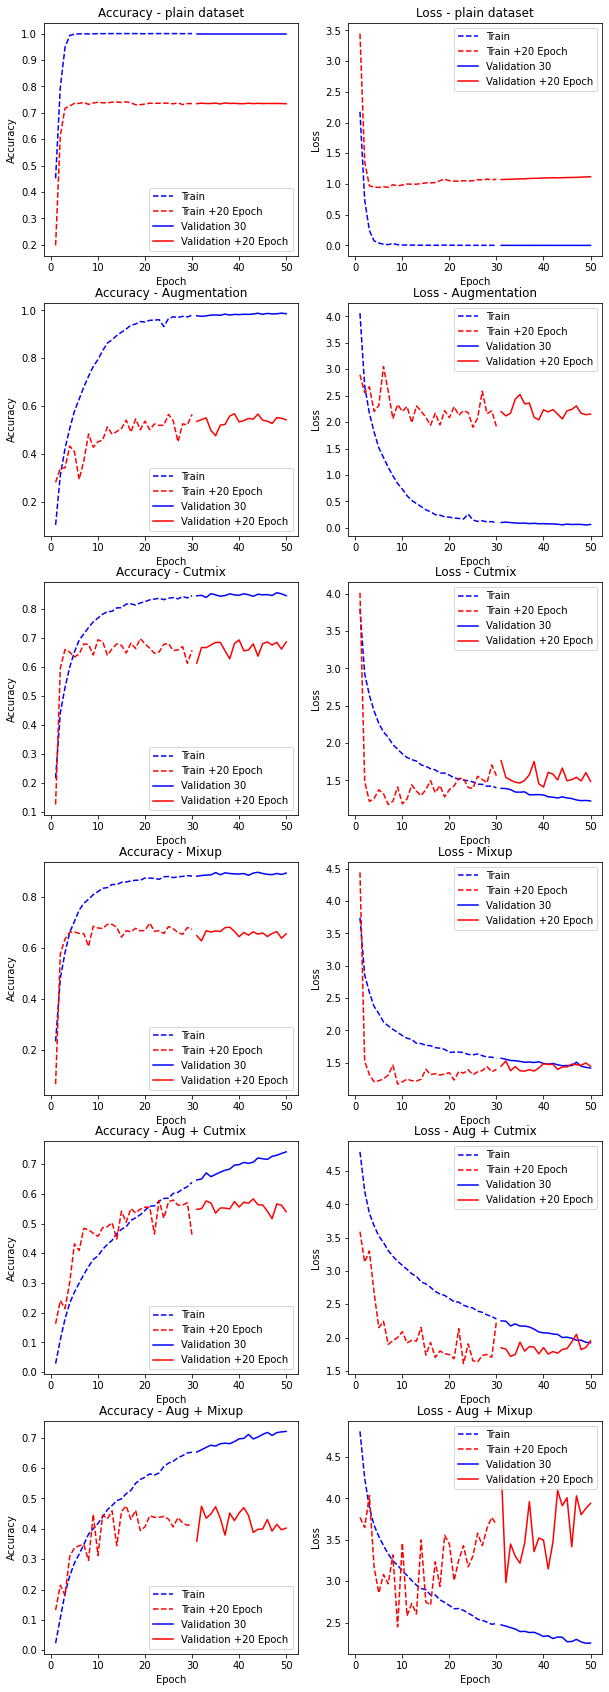

In [28]:


fig = plt.figure(figsize = (10, 30))

plt.subplot(6,2,1)
plt.plot(epoch[:30], res_plain['accuracy'], 'b--')
plt.plot(epoch[:30], res_plain['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_plain2['accuracy'],'b-')
plt.plot(epoch[30:], res_plain2['val_accuracy'],'r-')

plt.title('Accuracy - plain dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,2)
plt.plot(epoch[:30], res_plain['loss'], 'b--')
plt.plot(epoch[:30], res_plain['val_loss'], 'r--')
plt.plot(epoch[30:], res_plain2['loss'],'b-')
plt.plot(epoch[30:], res_plain2['val_loss'],'r-')

plt.title('Loss - plain dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

plt.subplot(6,2,3)
plt.plot(epoch[:30], res_aug['accuracy'], 'b--')
plt.plot(epoch[:30], res_aug['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_aug2['accuracy'],'b-')
plt.plot(epoch[30:], res_aug2['val_accuracy'],'r-')
plt.title('Accuracy - Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,4)
plt.plot(epoch[:30], res_aug['loss'], 'b--')
plt.plot(epoch[:30], res_aug['val_loss'], 'r--')
plt.plot(epoch[30:], res_aug2['loss'],'b-')
plt.plot(epoch[30:], res_aug2['val_loss'],'r-')
plt.title('Loss - Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

plt.subplot(6,2,5)
plt.plot(epoch[:30], res_cutmix['accuracy'], 'b--')
plt.plot(epoch[:30], res_cutmix['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_cutmix2['accuracy'],'b-')
plt.plot(epoch[30:], res_cutmix2['val_accuracy'],'r-')
plt.title('Accuracy - Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,6)
plt.plot(epoch[:30], res_cutmix['loss'], 'b--')
plt.plot(epoch[:30], res_cutmix['val_loss'], 'r--')
plt.plot(epoch[30:], res_cutmix2['loss'],'b-')
plt.plot(epoch[30:], res_cutmix2['val_loss'],'r-')
plt.title('Loss - Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

plt.subplot(6,2,7)
plt.plot(epoch[:30], res_mixup['accuracy'], 'b--')
plt.plot(epoch[:30], res_mixup['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_mixup2['accuracy'],'b-')
plt.plot(epoch[30:], res_mixup2['val_accuracy'],'r-')
plt.title('Accuracy - Mixup')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,8)
plt.plot(epoch[:30], res_mixup['loss'], 'b--')
plt.plot(epoch[:30], res_mixup['val_loss'], 'r--')
plt.plot(epoch[30:], res_mixup2['loss'],'b-')
plt.plot(epoch[30:], res_mixup2['val_loss'],'r-')
plt.title('Loss - Mixup')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

plt.subplot(6,2,9)
plt.plot(epoch[:30], res_aug_cutmix['accuracy'], 'b--')
plt.plot(epoch[:30], res_aug_cutmix['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_aug_cutmix2['accuracy'],'b-')
plt.plot(epoch[30:], res_aug_cutmix2['val_accuracy'],'r-')
plt.title('Accuracy - Aug + Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,10)
plt.plot(epoch[:30], res_aug_cutmix['loss'], 'b--')
plt.plot(epoch[:30], res_aug_cutmix['val_loss'], 'r--')
plt.plot(epoch[30:], res_aug_cutmix2['loss'],'b-')
plt.plot(epoch[30:], res_aug_cutmix2['val_loss'],'r-')
plt.title('Loss - Aug + Cutmix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

plt.subplot(6,2,11)
plt.plot(epoch[:30], res_aug_mixup['accuracy'], 'b--')
plt.plot(epoch[:30], res_aug_mixup['val_accuracy'], 'r--')
plt.plot(epoch[30:], res_aug_mixup2['accuracy'],'b-')
plt.plot(epoch[30:], res_aug_mixup2['val_accuracy'],'r-')
plt.title('Accuracy - Aug + Mixup')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='lower right')

plt.subplot(6,2,12)
plt.plot(epoch[:30], res_aug_mixup['loss'], 'b--')
plt.plot(epoch[:30], res_aug_mixup['val_loss'], 'r--')
plt.plot(epoch[30:], res_aug_mixup2['loss'],'b-')
plt.plot(epoch[30:], res_aug_mixup2['val_loss'],'r-')
plt.title('Loss - Aug + Mixup')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Train +20 Epoch', 'Validation 30', 'Validation +20 Epoch'], loc='upper right')

- Train Accuracy
50 에폭 후에도 Aug + Cutmix와 Aug + Mixup 의 training accuracy는 best performance에 이르지 못했습니다  
지속적인 우상향의 추세를 보이므로, 해당 데이터셋의 어그멘테이션 사용으로 모델은 아직 trainable 하다는 것을 내포합니다  
다른 모델의 경우, 최적의 accuracy에 수렴한 듯 합니다  

- Validation 
전체적으로 지속적인 accuracy 증감이 없습니다  
loss는 지속적으로 증가하는 추세이며, 특히 aug + mixup의 경우 안정적이지 않음이 도드라집니다

### Tuning   
SGD > Adam으로 모델 개선이 이루어지는지 확인해보겠습니다  

In [ ]:
####

In [21]:
EPOCH = 30
LEARNING_RATE = 0.01

In [22]:
def train_step_tuning(model_name, dataset) :
    
    model =  keras.models.load_model(model_name)
    
    model.compile(
    loss='categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
    )
    
    history = model.fit(
    dataset, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
    )
    
    print("tuning done : ", model_name)
    
    model.save(model_name + "_tune")
    del model
    
    return history

In [25]:
def history_to_csv(history, filename):
    hist_df = pd.DataFrame(history.history) 
    with open(filename, mode='w') as f:
        hist_df.to_csv(f)

# 회고  
- 메모리 관리를 중간중간 해서 쾌적하게 작업할 수 있었습니다  
앞으로 정말 중요하게 사용해야 할 기법인듯  
- 스트링 포멧 혹은 함수를 쓰는건 단순히 반복작업을 용이하게 하기 위함이 아닌, 변수 할당이 잘못됨을 방지할수도 있는 좋은 방법이 될듯  
#### 추가로 30epoch의 optimizer를 sgd > adam으로 변경하여 model tuning을 진행하였지만, 변수 할당이 올바르게 이루어지지 않아 데이터가 잘못 기록되었습니다   
생각하는 해결책에 대해 해당 코드의 아래부분에 제시해두었으며, 이후 이 방법이 잘 이루어지는지 확인해 보겠습니다
- 중간에 데이터셋도 섞을걸  
이라는 생각이 들었습니다 트레인 3번을 나누어 진행할 동안에 말입니다  

### 실험조건의 통제  
OOM 문제로 여러번 다운이 되어, 모델과 데이터셋을 다시 로드하여 작업을 진행하였습니다  
이 때, 모델은 train을 성공적으로 마친 후에만 저장할 수 있도록 하였지만,  
train을 위한 데이터셋의 경우 커널 다운 후 다시 시작할 때 shuffle했기 때문에 데이터의 순서가 앞과 달라졌고,  
특히 aug & aug + @ 실험에서 생성되었을 이미지는 랜덤하게 변형되었을 것입니다  
이는 같은 데이터셋을 전체 학습하기 때문에, 실험의 조건이 통제가 된것인지, 아니면 달라진것으로 판단해야될지 궁금합니다  